# Neural Network: Step by step

In [1]:
#import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5py   #store vast amounts of numerical data and easily manipulate that data from NumPy
#from dnn_utils import sigmoid, sigmoid_backward, relu, relu_backward

import scipy
from PIL import Image
from scipy import ndimage

import copy
%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

## Load and Process the Dataset

In [3]:
def load_data():
    
    train_dataset = h5py.File('train_catvnoncat.h5', "r")
    train_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('test_catvnoncat.h5', "r")
    test_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_y = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_y = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_x_orig, train_y, test_x_orig, test_y, classes



In [4]:
# Example of a picture
train_x_orig, train_y, test_x_orig, test_y, classes = load_data()
#index = 10
#plt.imshow(train_x_orig[index])
#print ("y = " + str(train_y[0,index]) + ". It's a " + classes[train_y[0,index]].decode("utf-8") +  " picture.")

In [5]:
# Explore your dataset 
m_train = train_x_orig.shape[0]
num_px = train_x_orig.shape[1]
m_test = test_x_orig.shape[0]

print ("Number of training examples: " + str(m_train))
print ("Number of testing examples: " + str(m_test))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_x_orig shape: " + str(train_x_orig.shape))
print ("train_y shape: " + str(train_y.shape))
print ("test_x_orig shape: " + str(test_x_orig.shape))
print ("test_y shape: " + str(test_y.shape))

Number of training examples: 209
Number of testing examples: 50
Each image is of size: (64, 64, 3)
train_x_orig shape: (209, 64, 64, 3)
train_y shape: (1, 209)
test_x_orig shape: (50, 64, 64, 3)
test_y shape: (1, 50)


In [6]:
# Reshape the training and test examples 
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T   # The "-1" makes reshape flatten the remaining dimensions
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T

# Standardize data to have feature values between 0 and 1.
train_x = train_x_flatten/255.
test_x = test_x_flatten/255.

print ("train_x's shape: " + str(train_x.shape))
print ("test_x's shape: " + str(test_x.shape))

train_x's shape: (12288, 209)
test_x's shape: (12288, 50)


## L-Layer Neural Network
## Initialize parameters

In [13]:
def initialize_parameters_deep(layer_dims):
    """
    Arguments:
    layer_dims -- contains dimensions of each layer in the network
    n_x -- size of the input layer
    n_h -- size of the hidden layer
    n_y -- size of the output layer

    Returns:
    parameters -- Python dictionary containing parameters:
                    W1 -- weight matrix of shape (n_h, n_x)
                    b1 -- weight matrix of shape (n_h, 1)
                    W1 -- weight matrix of shape (n_y, n_h)
                    b2 -- weight matrix of shape (n_y, 1)
   """

    parameters = {}
    L = len(layer_dims) # number of layers in the network

    for l in range(1, L):
        parameters["W" + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) * 0.01
        parameters["b" + str(l)] = np.zeros((layer_dims[l], 1))
        
        assert(parameters['W' + str(l)].shape == (layer_dims[l], layer_dims[l - 1]))
        assert(parameters['b' + str(l)].shape == (layer_dims[l], 1))

        
    return parameters

## He Initialization

In [16]:
# GRADED FUNCTION: initialize_parameters_he

def initialize_parameters_he(layers_dims):
    """
    Arguments:
    layer_dims -- python array (list) containing the size of each layer.
    
    Returns:
    parameters -- python dictionary containing your parameters "W1", "b1", ..., "WL", "bL":
                    W1 -- weight matrix of shape (layers_dims[1], layers_dims[0])
                    b1 -- bias vector of shape (layers_dims[1], 1)
                    ...
                    WL -- weight matrix of shape (layers_dims[L], layers_dims[L-1])
                    bL -- bias vector of shape (layers_dims[L], 1)
    """
    
    np.random.seed(3)
    parameters = {}
    L = len(layers_dims) - 1 # integer representing the number of layers
     
    for l in range(1, L + 1):
        parameters['W' + str(l)] = np.random.randn(layers_dims[l],layers_dims[l-1])*np.sqrt(2/layers_dims[l-1])
        parameters['b' + str(l)] = np.zeros((layers_dims[l], 1))
        
    return parameters

## Forward Propagation

In [19]:
def linear_forward(A,W,b):

    """
    Arguments:
    A -- Activations from previous layer (or input data): (size of the previous layer, number of examples)
    W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
    b -- bias vector, numpy array of shape (size of the current layer, 1)

    Returns:
    Z -- input of the activation function 
    cache -- a Python tuple containing A, W, and b stored for computing the backward propagation
    """
    Z = np.dot(W,A) + b

    cache = (A, W, b)

    return Z, cache

In [21]:
def sigmoid(Z):
    """
    Implements the sigmoid activation in numpy
    
    Arguments:
    Z -- numpy array of any shape
    
    Returns:
    A -- output of sigmoid(z), same shape as Z
    cache -- returns Z as well, useful during backpropagation
    """
    
    A = 1/(1+np.exp(-Z))
    cache = Z
    
    return A, cache

def relu(Z):
    """
    Implement the RELU function.

    Arguments:
    Z -- Output of the linear layer, of any shape

    Returns:
    A -- Post-activation parameter, of the same shape as Z
    cache -- a python dictionary containing "A" ; stored for computing the backward pass efficiently
    """
    
    A = np.maximum(0,Z)
    
    assert(A.shape == Z.shape)
    
    cache = Z 
    return A, cache

In [23]:
def relu_backward(dA, cache):
    """
    Implement the backward propagation for a single RELU unit.

    Arguments:
    dA -- post-activation gradient, of any shape
    cache -- 'Z' where we store for computing backward propagation efficiently

    Returns:
    dZ -- Gradient of the cost with respect to Z
    """
    
    Z = cache
    dZ = np.array(dA, copy=True) # just converting dz to a correct object.
    
    # When z <= 0, you should set dz to 0 as well. 
    dZ[Z <= 0] = 0
    
    assert (dZ.shape == Z.shape)
    
    return dZ

def sigmoid_backward(dA, cache):
    """
    Implement the backward propagation for a single SIGMOID unit.

    Arguments:
    dA -- post-activation gradient, of any shape
    cache -- 'Z' where we store for computing backward propagation efficiently

    Returns:
    dZ -- Gradient of the cost with respect to Z
    """
    
    Z = cache
    
    s = 1/(1+np.exp(-Z))
    dZ = dA * s * (1-s)
    
    assert (dZ.shape == Z.shape)
    
    return dZ

In [25]:
def linear_activation_forward(A_prev, W, b, activation):

    if activation == "sigmoid":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = sigmoid(Z)

    elif activation == "relu":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = relu(Z)
        
    cache = (linear_cache, activation_cache)

    return A, cache

In [27]:
def L_model_forward(X, parameters):
    """
    Implement forward propagation for the [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID computation
    
    Arguments:
    X -- data, numpy array of shape (input size, number of examples)
    parameters -- output of initialize_parameters_deep()
    
    Returns:
    AL -- activation value from the output (last) layer
    caches -- list of caches containing:
                every cache of linear_activation_forward() (there are L of them, indexed from 0 to L-1)
    """
    caches = []
    A = X
    L = len(parameters) //2   #number of layers in the neural network

    for l in range(1,L):
        A_prev = A
        A, cache = linear_activation_forward(A_prev, parameters["W" + str(l)], parameters["b" + str(l)], activation = "relu")
        caches.append(cache)
    AL, cache = linear_activation_forward(A, parameters["W" + str(L)], parameters["b" + str(L)], activation = "sigmoid")
    caches.append(cache)

    return AL, caches

In [29]:
def compute_cost(AL, Y):
    """
    Arguments:
    AL -- probability vector corresponding to your label predictions, shape (1, number of examples)
    Y -- true "label" vector (for example: containing 0 if non-cat, 1 if cat), shape (1, number of examples)
    """
    
    m = Y.shape[1]
    cost = -np.sum(np.multiply(Y, np.log(AL)) + np.multiply((1  - Y), np.log(1-AL)))/m

    cost = np.squeeze(cost)  # To make sure the cost's shape is what we expect (e.g. this turns [[17]] into 17).
    assert(cost.shape == ())
    
    return cost

In [31]:
def linear_backward(dZ, cache):

    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = (np.dot(dZ, A_prev.T))/m
    db = (np.sum(dZ, axis = 1, keepdims = True))/m
    dA_prev = np.dot(W.T, dZ)

    return dA_prev, dW, db

In [33]:
def linear_activation_backward(dA, cache, activation):

    linear_cache, activation_cache = cache
    
    if activation == "relu":
        
        dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db =linear_backward(dZ, linear_cache)
        
    elif activation == "sigmoid":
       
        dZ = sigmoid_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
        
    return dA_prev, dW, db

In [35]:
def L_model_backward(AL, Y, caches):

    grads = {}
    L = len(caches) # the number of layers
    m = AL.shape[1]
    Y = Y.reshape(AL.shape) # after this line Y is the same shape as AL print("L = "+str(L))
    
    # Initializing the backpropagation
    dAL = -np.divide(Y , AL) + np.divide((1-Y), (1-AL))

    # Lth layer (SIGMOID -> LINEAR) gradients. Inputs: "AL, Y, caches". Outputs: "grads["dAL"], grads["dWL"], grads["dbL"]
    current_cache = caches[L-1]
    dA, dW, db = linear_activation_backward(dAL, current_cache, activation = "sigmoid")
    grads["dA" + str(L-1)] = dA
    grads["dW" + str(L)] = dW
    grads["db" + str(L)] = db
    
    for l in reversed(range(L-1)):
        current_cache = caches[l]
        dA, dW, db = linear_activation_backward(dA, current_cache, activation = "relu")

        grads["dA" + str(l)] = dA
        grads["dW" + str(l+1)] = dW
        grads["db" + str(l+1)] = db
    
    return grads

In [37]:
#update parameters

def update_parameters(parameters, grads, learning_rate):

    L = len(parameters) //2  # number of layers in the neural network
    parameters = copy.deepcopy(parameters)
                      
    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - np.dot(learning_rate, grads["dW" + str(l+1)])
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - np.dot(learning_rate, grads["db" + str(l+1)])

    return parameters

## L-Layer Model

In [40]:
## CONSTANT ##
layers_dims = [12288, 20, 7, 5, 1]  # 4-layer model

In [42]:
def L_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):
    """
    Implements a L-layer neural network: [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID.
    
    Arguments:
    X -- input data, of shape (n_x, number of examples)
    Y -- true "label" vector (containing 1 if cat, 0 if non-cat), of shape (1, number of examples)
    layers_dims -- list containing the input size and each layer size, of length (number of layers + 1).
    learning_rate -- learning rate of the gradient descent update rule
    num_iterations -- number of iterations of the optimization loop
    print_cost -- if True, it prints the cost every 100 steps
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """

    np.random.seed(1)
    costs = []                         # keep track of cost
    
#    parameters = initialize_parameters_deep(layers_dims)
    parameters = initialize_parameters_he(layers_dims)
    # Loop (gradient descent)
    for i in range(0, num_iterations):

        # Forward propagation: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID.
        AL, caches = L_model_forward(X, parameters)
       
        # Compute cost.
        cost = compute_cost(AL, Y)
  
        # Backward propagation.
       
        grads = L_model_backward(AL, Y, caches)

        parameters = update_parameters(parameters, grads, learning_rate)
 
        # Print the cost every 100 iterations
        if print_cost and i % 100 == 0 or i == num_iterations - 1:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
        if i % 100 == 0 or i == num_iterations:
            costs.append(cost)

    return parameters, costs

def plot_costs(costs, learning_rate=0.0075):
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()

## Train the model

Cost after iteration 0: 0.8116017481136114
Cost after iteration 100: 0.6676695646220321
Cost after iteration 200: 0.6339824668918083
Cost after iteration 300: 0.6057467650054879
Cost after iteration 400: 0.5629711332996643
Cost after iteration 500: 0.4159412653163022
Cost after iteration 600: 0.3204714324288978
Cost after iteration 700: 0.2324734795290719
Cost after iteration 800: 0.1484757750084844
Cost after iteration 900: 0.08750257977951137
Cost after iteration 1000: 0.057387705941067235
Cost after iteration 1100: 0.039936524912202176
Cost after iteration 1200: 0.030270549594624826
Cost after iteration 1300: 0.024070231198004263
Cost after iteration 1400: 0.01965655605935522
Cost after iteration 1500: 0.016491698536305225
Cost after iteration 1600: 0.014169402307804968
Cost after iteration 1700: 0.012192418435785701
Cost after iteration 1800: 0.010697445643829257
Cost after iteration 1900: 0.009464245952082277
Cost after iteration 2000: 0.00848784945499111
Cost after iteration 2100

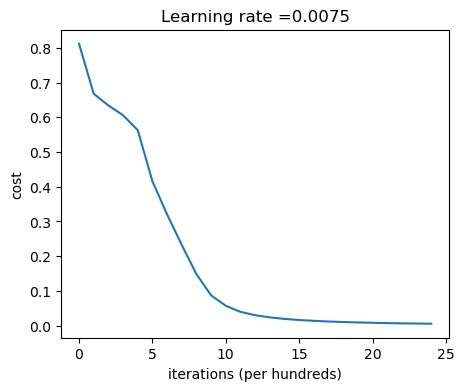

In [45]:
parameters, costs = L_layer_model(train_x, train_y, layers_dims, learning_rate = 0.0075, num_iterations = 2500, print_cost = True) 
plot_costs(costs, learning_rate = 0.0075)

In [47]:
def predict(parameters, X, y):
    
    """
    This function is used to predict the results of an L-layer neural network.
    
    Arguments:
    X -- data set of examples you would like to label
    parameters -- parameters of the trained model
    
    Returns:
    p -- predictions for the given dataset X
    """
    m = X.shape[1]
    p = np.zeros((1,m))

    #Forward propagation
    probas, caches = L_model_forward(X, parameters)

    #Convert probas to 0/1 predictions
    for i in range(0, m):
        if probas[0, i] > 0.5:
            p[0,i] = 1
        else:
            p[0,i] = 0
    
    print("Accuracy: "  + str(np.sum((p == y)/m)))    
    return p

In [49]:
pred_train = predict(parameters, train_x, train_y)

Accuracy: 0.9999999999999998


In [51]:
pred_test = predict(parameters,test_x, test_y)

Accuracy: 0.8


In [55]:
def print_mislabeled_images(classes, X, y, p):
    """
    Plots images where predictions and truth were different.
    X -- dataset
    y -- true labels
    p -- predictions
    """
    a = p + y
    mislabeled_indices = np.asarray(np.where(a == 1))
    plt.rcParams['figure.figsize'] = (40.0, 40.0) # set default size of plots
    num_images = len(mislabeled_indices[0])
    for i in range(num_images):
        index = mislabeled_indices[1][i]
        
        plt.subplot(2, num_images, i + 1)
        plt.imshow(X[:,index].reshape(64,64,3), interpolation='nearest')
        plt.axis('off')
        plt.title("Prediction: " + classes[int(p[0,index])].decode("utf-8") + " \n Class: " + classes[y[0,index]].decode("utf-8"))

In [57]:
print_mislabeled_images(classes, test_x, test_y, pred_test)